In [1]:
import molgrid
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
molgrid.set_random_seed(0)
np.random.seed(0)
batch_size = 50
datadir = os.getcwd() +'/../data'
fname = datadir+"/small.types"

In [3]:
def create_model(dims):
    """ Creates a 3D CNN by defining and applying layers simultaneously. """

    input_layer = keras.layers.Input(shape=dims)
    pool0 = keras.layers.MaxPooling3D(data_format="channels_first")(input_layer)
    conv1 = keras.layers.Conv3D(filters=32, kernel_size=3, data_format="channels_first", activation="relu")(pool0)
    pool1 = keras.layers.MaxPooling3D(data_format="channels_first")(conv1)
    conv2 = keras.layers.Conv3D(filters=64, kernel_size=3, data_format="channels_first", activation="relu")(pool1)
    pool2 = keras.layers.MaxPooling3D(data_format="channels_first")(conv2)
    conv3 = keras.layers.Conv3D(filters=128, kernel_size=3, data_format="channels_first", activation="relu")(pool2)

    flatten = keras.layers.Flatten(data_format="channels_first")(conv3)

    fc1 = keras.layers.Dense(2,activation='softmax')(flatten)

    # Define and return model
    model = keras.models.Model(inputs=input_layer, outputs=fc1)
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9), loss="sparse_categorical_crossentropy")

    return model

In [4]:
e = molgrid.ExampleProvider(data_root=datadir+"/structs",balanced=True,shuffle=True)
e.populate(fname)

In [5]:
gmaker = molgrid.GridMaker()
dims = gmaker.grid_dimensions(e.num_types())
tensor_shape = (batch_size,)+dims
model = create_model(dims)

In [6]:
labels = molgrid.MGrid1f(batch_size)
input_tensor = molgrid.MGrid5f(*tensor_shape)

In [7]:
losses = []
# train for 500 iterations
for iteration in range(500):
    # load data
    batch = e.next_batch(batch_size)

    gmaker.forward(batch, input_tensor, 0, random_rotation=True)
    batch.extract_label(0, labels)

    loss = model.train_on_batch(input_tensor.tonumpy(), labels.tonumpy())
    losses.append(float(loss))

In [8]:
%matplotlib inline

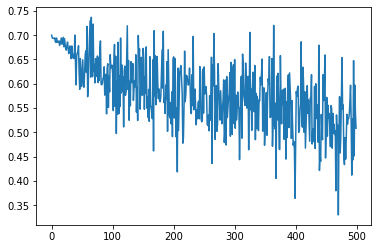

In [9]:
plt.plot(losses)